<a href="https://colab.research.google.com/github/jansoe/AICA/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning für Bildklassifikation

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.applications import mobilenet_v2

model = mobilenet_v2.MobileNetV2(
    input_shape = (224, 224, 3),
    weights = 'imagenet'
)

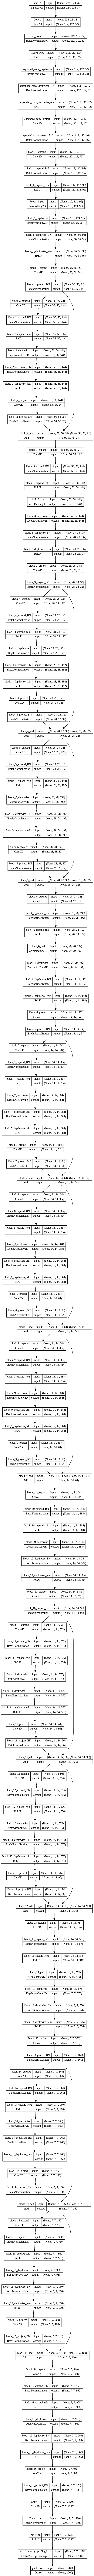

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

Bildklassifikation: Hunde gegen Katzen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cat_image_folder = './drive/My Drive/CatVSDog_small/cat/'
dog_image_folder = './drive/My Drive/CatVSDog_small/dog/'

In [ ]:
from tqdm import tqdm # tqdm gibt uns einen Fortschritsbalken
from tensorflow.keras import preprocessing # preprocessing funktionalität von keras
import glob # dateisystemfunktionalität

In [ ]:
cat_images = [] # eine leere Liste zum Sammeln der Bilder 
# glob gibt alle Dateinamen in einem Ordner als Liste zurück
cat_files = glob.glob(cat_image_folder+'*') 
for cat_file in tqdm(cat_files):
    # das bild wird mit einer vorgegebenen größe geladen
    cat_image =  preprocessing.image.load_img(cat_file, target_size=(224,224))
    # ... und in einen Array umgewandelt.
    cat_image_array = preprocessing.image.img_to_array(cat_image)
    # das Bild wird an die Liste angehängt.
    cat_images.append(cat_image_array)
# Am Ende wird die Liste von bildern in einen Array umgewandelt
cat_images = np.array(cat_images) 

print(cat_images.shape)

100%|██████████| 69/69 [00:44<00:00,  1.54it/s]

(69, 224, 224, 3)


In [ ]:
dog_images = []
dog_files = glob.glob(dog_image_folder+'*')
for dog_file in tqdm(dog_files):
    dog_image = preprocessing.image.load_img(dog_file, target_size=(224,224))
    dog_images.append(preprocessing.image.img_to_array(dog_image))
dog_images = np.array(dog_images)

100%|██████████| 49/49 [00:28<00:00,  1.75it/s]


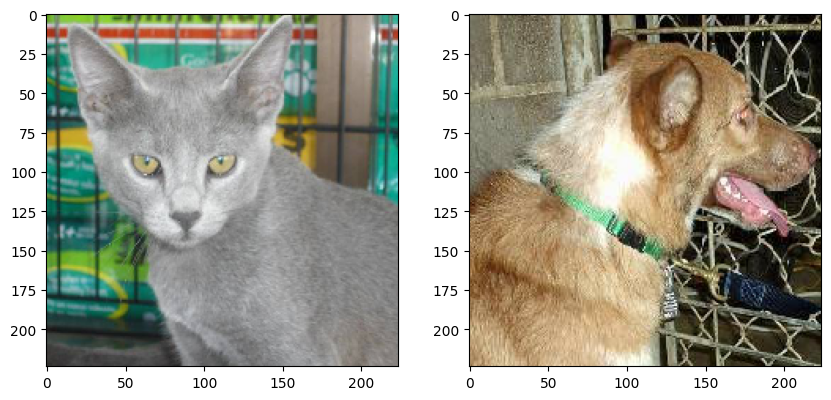

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(preprocessing.image.array_to_img(cat_images[0]))

plt.subplot(122)
_ =plt.imshow(preprocessing.image.array_to_img(dog_images[0]))

In [ ]:
cat_image_inputs = mobilenet_v2.preprocess_input(cat_images)
dog_image_inputs = mobilenet_v2.preprocess_input(dog_images)

In [ ]:
base_model = mobilenet_v2.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights='imagenet'
)

9406464/9406464 [==============================] - 1s 0us/step


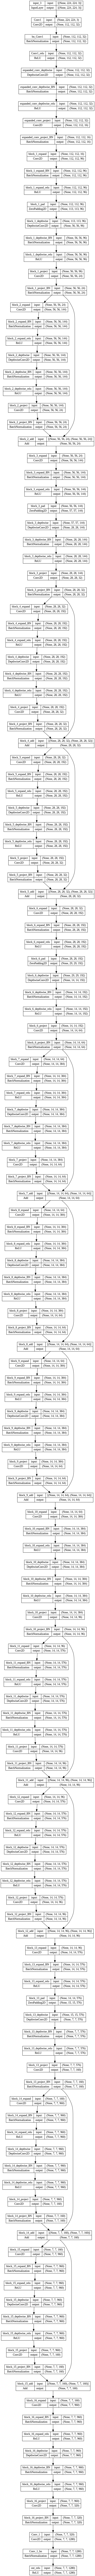

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = tf.keras.layers.Dense(
    units=1, 
    activation='sigmoid', #Aktivierungsfunktion für binäre Klassifikationsprobleme 
    name='out'
)

In [ ]:
base_model.trainable = False 

In [ ]:
new_model = tf.keras.Sequential()

new_model.add(base_model)
new_model.add(global_average_layer)
new_model.add(prediction_layer)

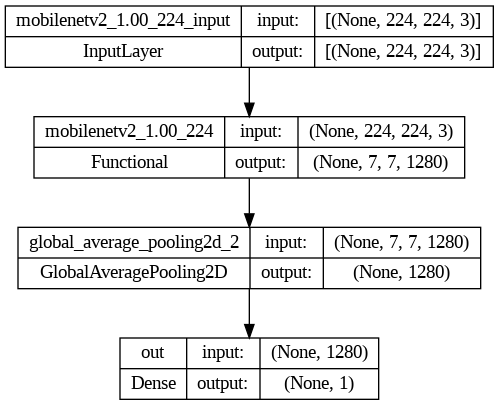

In [ ]:
tf.keras.utils.plot_model(new_model, show_shapes=True)

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 out (Dense)                 (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
new_model.compile(
    optimizer='adam',            # bei tiefen Netzen häufig verwendeter Optimierungsalgorithmus
    loss='binary_crossentropy',  # bei Klassifikation mit zwei Klassen nehmen wir 'binary_crossentropy' als Fehlermaß
    metrics=['accuracy']         # zum Beobachten des Trainings wählen wir wieder die Accuracy
)

In [ ]:
len(dog_image_inputs)

49

In [ ]:
num_train = 30

# Wir schmeißen die ersten num_train Katzen- und Hundebilder in einen Topf
train_images = np.vstack([cat_image_inputs[0:num_train], dog_image_inputs[0:num_train]])
# Jedem Katzenbild ordnen wir das Label 0 zu, jedem Hundebild das Label 1
train_labels = np.hstack([np.zeros(num_train), np.ones(num_train)])
print(train_images.shape)
print(train_labels.shape)

# und aus jeweils 100 Katzen- und Hundebildern bauen wir uns einen Testdatensatz
test_images = np.vstack([cat_image_inputs[num_train:], dog_image_inputs[num_train:]])
test_labels = np.hstack([np.zeros(len(cat_image_inputs[num_train:])), np.ones(len(dog_image_inputs[num_train:]))])

(60, 224, 224, 3)
(60,)


In [ ]:
new_model.fit(
    x = train_images,
    y = train_labels,
    shuffle=True, # wir durchmischen unsere Daten, damit nicht zuerst alle Katzen und dann alle Hunde kommen
    epochs=30,                                      
    validation_data = (test_images, test_labels)
)

Epoch 1/30
2/2 [==============================] - 14s 9s/step - loss: 0.7685 - accuracy: 0.5000 - val_loss: 0.6566 - val_accuracy: 0.6034
Epoch 2/30
2/2 [==============================] - 4s 3s/step - loss: 0.6172 - accuracy: 0.6500 - val_loss: 0.5440 - val_accuracy: 0.7586
Epoch 3/30
2/2 [==============================] - 8s 7s/step - loss: 0.4980 - accuracy: 0.7833 - val_loss: 0.4546 - val_accuracy: 0.8276
Epoch 4/30
2/2 [==============================] - 4s 3s/step - loss: 0.4006 - accuracy: 0.8667 - val_loss: 0.3817 - val_accuracy: 0.9138
Epoch 5/30
2/2 [==============================] - 5s 4s/step - loss: 0.3194 - accuracy: 0.9667 - val_loss: 0.3238 - val_accuracy: 0.9310
Epoch 6/30
2/2 [==============================] - 9s 7s/step - loss: 0.2561 - accuracy: 0.9833 - val_loss: 0.2791 - val_accuracy: 0.9655
Epoch 7/30
2/2 [==============================] - 16s 10s/step - loss: 0.2083 - accuracy: 1.0000 - val_loss: 0.2423 - val_accuracy: 0.9655
Epoch 8/30
2/2 [======================

KeyboardInterrupt: ignored

In [ ]:
prediction = new_model.predict(test_images)

2/2 [==============================] - 4s 1s/step


IndexError: ignored

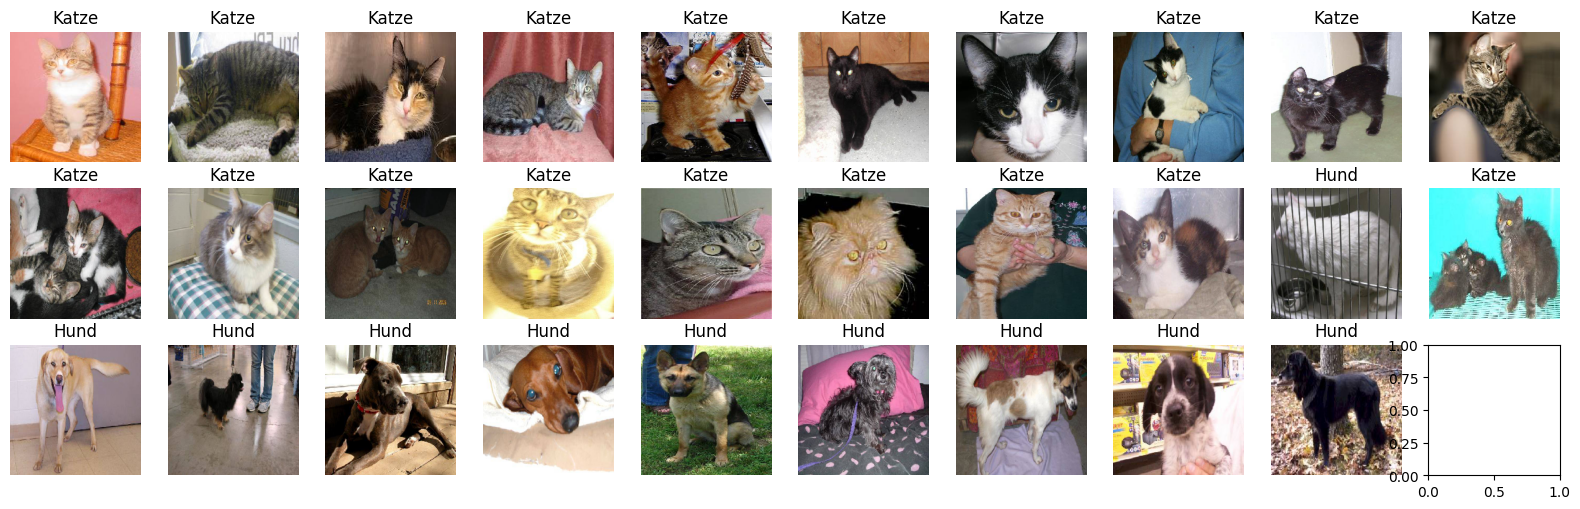

In [ ]:
plt.figure(figsize = (20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(preprocessing.image.array_to_img(test_images[2*i]))
    if prediction[2*i] < 0.5:
        label = 'Katze'
    else:
        label = 'Hund'
    plt.title(label)
    plt.axis('off')